In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

def load_and_flatten_data():
    (X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

    X_train_flat = X_train_full.reshape(X_train_full.shape[0], -1).astype('float32')
    X_test_flat = X_test_full.reshape(X_test_full.shape[0], -1).astype('float32')

    y_train_flat = y_train_full.flatten()
    y_test_flat = y_test_full.flatten()

    print("Original Shape:", X_train_full.shape)
    print("New 'Flat' Shape:", X_train_flat.shape)

    return X_train_flat, y_train_flat, X_test_flat, y_test_flat

X_train, y_train, X_test, y_test = load_and_flatten_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Original Shape: (50000, 32, 32, 3)
New 'Flat' Shape: (50000, 3072)


In [7]:
import numpy as np

def compute_distances(X_train, X_test, metric='euclidean', p=3):
    """
    Computes distance matrix with ALL 5 metrics required by the assignment.
    """
    num_test = X_test.shape[0]
    num_train = X_train.shape[0]
    dists = np.zeros((num_test, num_train))

    print(f"Computing {metric} distances...")

    if metric == 'euclidean':
        # (x-y)^2 = x^2 + y^2 - 2xy
        dists = np.sqrt(
            np.sum(X_test**2, axis=1, keepdims=True) +
            np.sum(X_train**2, axis=1) -
            2 * np.dot(X_test, X_train.T)
        )

    elif metric == 'manhattan':
        # L1: |x - y|
        for i in range(num_test):
            dists[i, :] = np.sum(np.abs(X_train - X_test[i, :]), axis=1)

    elif metric == 'minkowski':
        # Lp: sum(|x - y|^p)^(1/p)
        # We use p=3 as the default "Minkowski" test (since p=1 is Manhattan and p=2 is Euclidean)
        for i in range(num_test):
            dists[i, :] = np.sum(np.abs(X_train - X_test[i, :])**p, axis=1)**(1/p)

    elif metric == 'cosine':
        # Cosine Distance = 1 - Cosine Similarity
        norm_test = np.linalg.norm(X_test, axis=1, keepdims=True)
        norm_train = np.linalg.norm(X_train, axis=1, keepdims=True)
        similarity = np.dot(X_test, X_train.T) / (norm_test * norm_train.T + 1e-8)
        dists = 1 - similarity

    elif metric == 'hamming':
        # Hamming: Fraction of unequal positions
        # Note: For raw float pixels, "unequal" means "not exactly identical".
        for i in range(num_test):
            dists[i, :] = np.mean(X_train != X_test[i, :], axis=1)

    return dists

In [3]:
from collections import Counter

class KNearestNeighbor:
    def __init__(self):
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Training step.
        For KNN, this is just memorizing the data.
        """
        self.X_train = X
        self.y_train = y

    def predict(self, dists, k=1):
        """
        Predict labels for test data using the precomputed distance matrix.

        Inputs:
        - dists: Distance matrix from Step 2 (num_test, num_train)
        - k: The number of neighbors to vote

        Returns:
        - y_pred: Predicted labels for the test data
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            # 1. Find the Nearest Neighbors
            # The i-th row of 'dists' contains distances from Test Image i to all Train images.
            # np.argsort returns the INDICES of the data, sorted from smallest distance to largest.
            sorted_indices = np.argsort(dists[i, :])

            # We only care about the first 'k' indices (the closest ones)
            closest_indices = sorted_indices[:k]

            # 2. Get the Labels of those Neighbors
            # We use the indices to grab the actual labels (answers) from y_train
            closest_y = self.y_train[closest_indices]

            # 3. Majority Vote
            # Counter creates a dictionary counting occurrences (e.g., {6: 3, 2: 1})
            # most_common(1) returns the winner: [(Label, Count)]
            vote = Counter(closest_y).most_common(1)[0][0]

            y_pred[i] = vote

        return y_pred

In [4]:
def calculate_metrics(y_true, y_pred, num_classes=10):
    # 1. Accuracy
    # Check where the true label equals the predicted label
    # np.mean converts True/False to 1/0 and gives the percentage
    accuracy = np.mean(y_true == y_pred)

    # 2. Confusion Matrix
    # Create a 10x10 grid of zeros
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Loop through every single prediction
    # If the true label (t) is 3 and prediction (p) is 5, we add +1 to the box at row 3, col 5
    for t, p in zip(y_true, y_pred):
        conf_matrix[int(t), int(p)] += 1

    # 3. Precision & Recall (Macro Average)
    precision_sum = 0
    recall_sum = 0

    # We calculate metrics for EACH class (0 to 9) individually
    for c in range(num_classes):
        # True Positive (TP): Model said 'c', and it was actually 'c' (Diagonal of matrix)
        tp = conf_matrix[c, c]

        # False Positive (FP): Model said 'c', but it was something else (Sum of Column 'c' minus TP)
        fp = np.sum(conf_matrix[:, c]) - tp

        # False Negative (FN): It was actually 'c', but Model said something else (Sum of Row 'c' minus TP)
        fn = np.sum(conf_matrix[c, :]) - tp

        # Calculate for this specific class
        # We check if (tp+fp) > 0 to avoid dividing by zero (if the model never predicted this class)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_sum += precision
        recall_sum += recall

    # Average them out (Macro Average)
    macro_precision = precision_sum / num_classes
    macro_recall = recall_sum / num_classes

    return accuracy, conf_matrix, macro_precision, macro_recall

In [5]:
# ==========================================
# FIX: Subsetting Data for Speed
# ==========================================

# We take only the first 5,000 images for training
# and the first 500 images for testing.
X_train_subset = X_train[:5000]
y_train_subset = y_train[:5000]

X_test_subset = X_test[:500]
y_test_subset = y_test[:500]

print(f"Training on: {X_train_subset.shape[0]} images")
print(f"Testing on:  {X_test_subset.shape[0]} images")

# IMPORTANT: Update the variables so the Execution Loop uses the small set
X_train = X_train_subset
y_train = y_train_subset
X_test = X_test_subset
y_test = y_test_subset

Training on: 5000 images
Testing on:  500 images


In [8]:
# ==========================================
# 5. Main Execution Loop (Updated for All 5 Metrics)
# ==========================================

# Initialize
classifier = KNearestNeighbor()
classifier.fit(X_train, y_train)

# The full list of metrics from the assignment
k_values = [3, 4, 9, 20, 47]
distance_metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']

results = {}

print(f"--- Starting Experiments with {len(distance_metrics)} Metrics ---")

best_acc = 0
best_config = {}
best_preds = None

for metric in distance_metrics:
    # Compute distances (This might take time for Minkowski/Manhattan)
    dists = compute_distances(X_train, X_test, metric=metric, p=3)

    accuracies = []

    for k in k_values:
        y_pred = classifier.predict(dists, k=k)
        acc, _, _, _ = calculate_metrics(y_test, y_pred)
        accuracies.append(acc)

        print(f"Metric: {metric:10} | K: {k:2} | Accuracy: {acc:.4f}")

        # Track the winner
        if acc > best_acc:
            best_acc = acc
            best_config = {'k': k, 'metric': metric}
            best_preds = y_pred

    results[metric] = accuracies

print("\nExperiments Complete!")
print(f"🏆 BEST MODEL: {best_config['metric']} with K={best_config['k']} (Accuracy: {best_acc:.4f})")

--- Starting Experiments with 5 Metrics ---
Computing euclidean distances...
Metric: euclidean  | K:  3 | Accuracy: 0.2800
Metric: euclidean  | K:  4 | Accuracy: 0.2840
Metric: euclidean  | K:  9 | Accuracy: 0.2900
Metric: euclidean  | K: 20 | Accuracy: 0.2660
Metric: euclidean  | K: 47 | Accuracy: 0.2520
Computing manhattan distances...
Metric: manhattan  | K:  3 | Accuracy: 0.2980
Metric: manhattan  | K:  4 | Accuracy: 0.3080
Metric: manhattan  | K:  9 | Accuracy: 0.3020
Metric: manhattan  | K: 20 | Accuracy: 0.2880
Metric: manhattan  | K: 47 | Accuracy: 0.2720
Computing minkowski distances...
Metric: minkowski  | K:  3 | Accuracy: 0.2280
Metric: minkowski  | K:  4 | Accuracy: 0.2420
Metric: minkowski  | K:  9 | Accuracy: 0.2560
Metric: minkowski  | K: 20 | Accuracy: 0.2520
Metric: minkowski  | K: 47 | Accuracy: 0.2300
Computing cosine distances...
Metric: cosine     | K:  3 | Accuracy: 0.2900
Metric: cosine     | K:  4 | Accuracy: 0.2800
Metric: cosine     | K:  9 | Accuracy: 0.2760

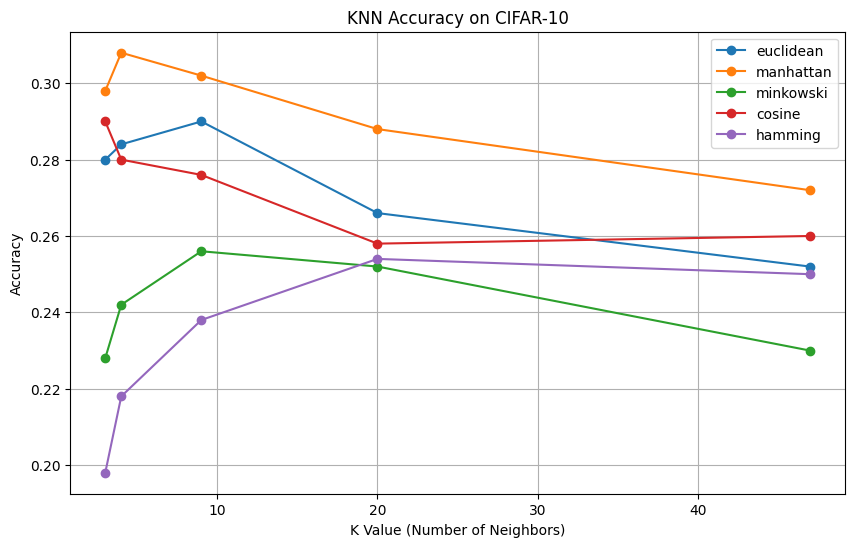


🏆 BEST MODEL: K=4, Metric=manhattan
Accuracy:  0.3080
Precision: 0.3785
Recall:    0.3011

Confusion Matrix:
(Rows = Actual Class, Columns = Predicted Class)


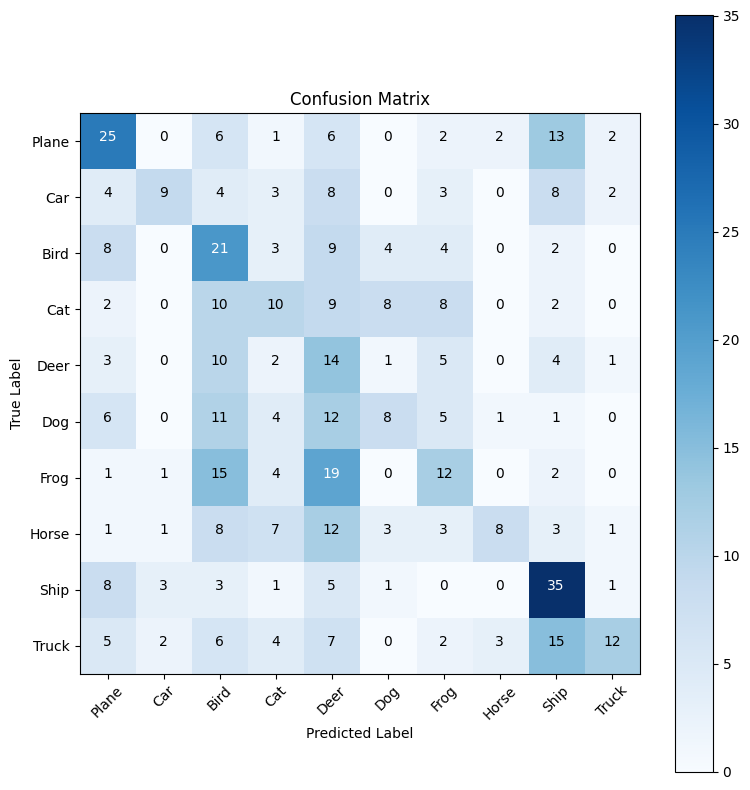

In [9]:
# ==========================================
# 6. Visualization & Final Report
# ==========================================

# 1. Plot Accuracy vs K for different metrics
plt.figure(figsize=(10, 6))

# Loop through our results dictionary and draw a line for each metric
for metric, accs in results.items():
    plt.plot(k_values, accs, marker='o', label=metric)

plt.title('KNN Accuracy on CIFAR-10')
plt.xlabel('K Value (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.legend() # Shows the box telling which color is which metric
plt.grid(True)
plt.show()

# 2. Detailed Report for the Winner
print("\n" + "="*40)
print(f"🏆 BEST MODEL: K={best_config['k']}, Metric={best_config['metric']}")
print("="*40)

# Recalculate metrics for the absolute best model found
final_acc, conf_mat, precision, recall = calculate_metrics(y_test, best_preds)

print(f"Accuracy:  {final_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nConfusion Matrix:")
print("(Rows = Actual Class, Columns = Predicted Class)")
# Using Matplotlib to make the confusion matrix look nice
plt.figure(figsize=(8, 8))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Print the numbers inside the squares
for i in range(10):
    for j in range(10):
        plt.text(j, i, str(conf_mat[i, j]),
                 horizontalalignment="center",
                 color="white" if conf_mat[i, j] > conf_mat.max() / 2 else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()